<a href="https://colab.research.google.com/github/Deeksha-Pandit/EVA4-S9/blob/master/S9_TrailGradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline

In [9]:
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-xv6nmgec
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-xv6nmgec
     |████████████████████████████████| 634kB 4.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=64514 sha256=f75b2d07db31df698dcaceb2f8a1a1181f8f1405277a4a271fc4f504e83c7625
  Stored in directory: /tmp/pip-ephem-wheel-cache-h0c5urn1/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=9ad225626944fc710d20b6641db8c8fe11a53824e9c0b04ffa2ea04430d7653f
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
  


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from albumentations import Compose, Normalize, HorizontalFlip, Cutout, Rotate
from albumentations.pytorch import ToTensor

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [11]:
class album_Compose:
  def __init__(self, train=False):
    self.train=train
    self.albumentations_transform_train = Compose([
                                            # Resize(256,256),
                                            # RandomCrop(224,224),
                                             Rotate((-30.0, 30.0)),
                                             HorizontalFlip(),
                                             Normalize(
                                                 mean=[0.485,0.456,0.406],
                                                 std=[0.229,0.224,0.225]
                                             ),
                                             Cutout(num_holes=1, max_h_size=16,max_w_size = 16,p = 0.5), # fillvalue is 0 after normalizing as mean is 0
                                             ToTensor()   
    ])
    self.albumentations_transform_test = Compose([
                                             Normalize(
                                                 mean=[0.485,0.456,0.406],
                                                 std=[0.229,0.224,0.225]
                                             ),
                                             ToTensor()   
    ])
  def __call__(self,img):
    img = np.array(img)
    if self.train:
      img = self.albumentations_transform_train(image = img)['image']
    else:
      img = self.albumentations_transform_test(image = img)['image']
    return img

"""transform = transforms.Compose(
    [transforms.RandomRotation(20),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])"""

SEED = 1


# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

Batch_size = 64
if cuda:
  Batch_size = 128
  

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=Batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=2)
train_compose = album_Compose(train=True)
test_compose = album_Compose()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_compose)
trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_compose)
testloader = torch.utils.data.DataLoader(testset, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

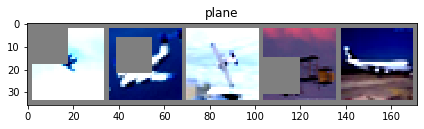

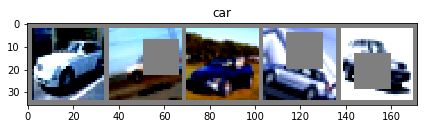

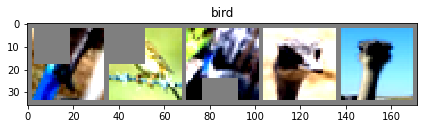

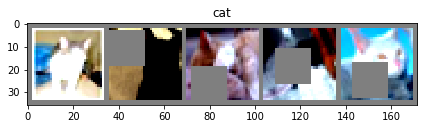

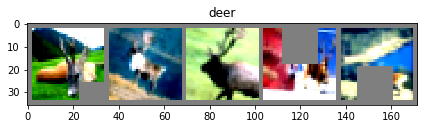

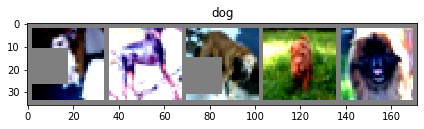

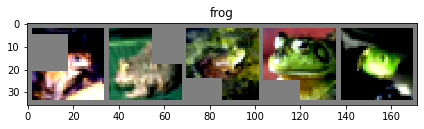

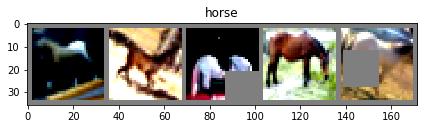

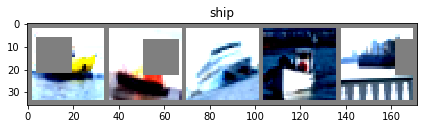

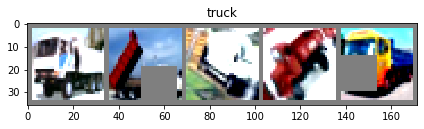

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

# functions to show an image
def imshow(img,c = ""):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(7,7))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')
    plt.title(c)

# get some random training images

dataiter = iter(trainloader)
images, labels = dataiter.next()
for i in range(10):
    index = [j for j in range(len(labels)) if labels[j] == i]
    imshow(torchvision.utils.make_grid(images[index[0:5]],nrow=5,padding=2,scale_each=True),classes[i])
# show images
#imshow(torchvision.utils.make_grid(images))
# print labels
#print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, dropout=0.0):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        self.dropout = dropout

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.dropout(out, p=self.dropout)
        out = self.bn2(self.conv2(out))
        out = F.dropout(out, p=self.dropout)
        out += self.shortcut(x)
        out = F.relu(out)
        out = F.dropout(out, p=self.dropout)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, dropout=0.0):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.dropout = dropout

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, dropout=self.dropout))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.dropout(out, p=self.dropout)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(dropout=0.0):
    return ResNet(BasicBlock, [2,2,2,2], dropout=0.12)

def ResNet34():
    return ResNet(BasicBlock, [3,4,6,3])

def ResNet50():
    return ResNet(Bottleneck, [3,4,6,3])

def ResNet101():
    return ResNet(Bottleneck, [3,4,23,3])

def ResNet152():
    return ResNet(Bottleneck, [3,8,36,3])


def test():
    net = ResNet18()
    y = net(torch.randn(1,3,32,32))
    print(y.size())
#test()


In [15]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
resnet = ResNet18().to(device)
summary(resnet, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [0]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)
scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [17]:
minibatch= int(len(trainset)/Batch_size)
for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    processed = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs,labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        pred = outputs.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(labels.view_as(pred)).sum().item()
        processed += len(inputs)

        if i == minibatch:    # print every mini-batches
            print('[%d, %5d] loss: %.3f,Acc: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000,100*correct/processed))
            running_loss = 0.0
    scheduler.step()
print('Finished Training')

[1,   391] loss: 0.326,Acc: 38.508
[2,   391] loss: 0.251,Acc: 53.404
[3,   391] loss: 0.217,Acc: 60.398
[4,   391] loss: 0.192,Acc: 64.982
[5,   391] loss: 0.177,Acc: 68.200
Finished Training


5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  plane plane truck  ship


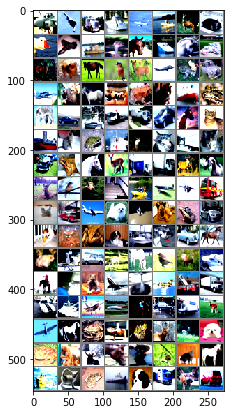

In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [19]:
outputs = resnet(images.to(device))
print(outputs)

tensor([[-0.2915, -1.4055,  1.1878,  ...,  1.9026, -2.8541, -1.1247],
        [ 4.6833, -1.9913,  4.1384,  ..., -2.3598,  0.8121, -2.9246],
        [-0.1805,  2.1398, -2.6489,  ..., -1.1260,  0.5652,  7.8970],
        ...,
        [-1.2897,  5.9212, -0.5937,  ..., -2.3545, -0.7661,  7.2685],
        [ 0.0819, -2.3473,  0.5171,  ...,  2.4850, -1.9913, -1.0947],
        [-0.2596,  7.1351, -2.1102,  ..., -0.7990, -0.4073,  2.6171]],
       device='cuda:0', grad_fn=<AddmmBackward>)


The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [20]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   deer plane truck  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.3f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 74.540 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [22]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 85 %
Accuracy of  bird : 88 %
Accuracy of   cat : 38 %
Accuracy of  deer : 71 %
Accuracy of   dog : 68 %
Accuracy of  frog : 72 %
Accuracy of horse : 63 %
Accuracy of  ship : 82 %
Accuracy of truck : 87 %


In [0]:
class GradCAM():
 def __init__(self, arch: torch.nn.Module, target_layer: torch.nn.Module):
        self.model_arch = arch

        self.gradients = dict()
        self.activations = dict()

        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]

        def forward_hook(module, input, output):
            self.activations['value'] = output

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)
 @classmethod
 def from_config(cls, arch: torch.nn.Module, model_type: str, layer_name: str):
    target_layer = layer_finders[model_type](arch, layer_name)
    return cls(arch, target_layer)

 def saliency_map_size(self, *input_size):
    device = next(self.model_arch.parameters()).device
    self.model_arch(torch.zeros(1, 3, *input_size, device=device))
    return self.activations['value'].shape[2:]

 def forward(self, input, class_idx=None, retain_graph=False):
    b, c, h, w = input.size()

    logit = self.model_arch(input)
    if class_idx is None:
        score = logit[:, logit.max(1)[-1]].squeeze()
    else:
        score = logit[:, class_idx].squeeze()

    self.model_arch.zero_grad()
    score.backward(retain_graph=retain_graph)
    gradients = self.gradients['value']
    activations = self.activations['value']
    b, k, u, v = gradients.size()

    alpha = gradients.view(b, k, -1).mean(2)
    # alpha = F.relu(gradients.view(b, k, -1)).mean(2)
    weights = alpha.view(b, k, 1, 1)

    saliency_map = (weights*activations).sum(1, keepdim=True)
    saliency_map = F.relu(saliency_map)
    saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
    saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
    saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data
    self.gradients.clear()
    self.activations.clear()
    return saliency_map, logit

    
 def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)




In [0]:
import cv2
def visualize_cam(mask, img, alpha=1.0):
    heatmap = (255 * mask.squeeze()).type(torch.uint8).cpu().numpy()
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b]) * alpha

    result = heatmap+img.cpu()
    result = result.div(result.max()).squeeze()

    return heatmap, result

In [0]:
import PIL
#img_name = '/Cat03.jpg','/plane.jpg'
img_path = '/content/Cat03.jpg','/content/plane.jpg' #sys.path[-1]+img_name

pil_image = []
for i,img in enumerate(img_path):
   pil_image.append(PIL.Image.open(img))
#pil_img = PIL.Image.open(img_path)
#pil_img

In [0]:
from torchvision import transforms
normed_torch_img = []
torch_img_list = []

for i in pil_image:
  torch_img = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor()
  ])(i).to(device)
  torch_img_list.append(torch_img)

  normed_torch_img .append(transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])(torch_img)[None])

In [0]:
from torchvision import transforms
import PIL
normed_torch_img = []
torch_img_list = []

#for i in pil_img:
torch_img = transforms.Compose([
      transforms.Resize((32, 32)),
      transforms.ToTensor()
      
])(pil_img).to(device)
torch_img_list.append(torch_img)

normed_torch_img .append(transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])(torch_img)[None])

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(img ):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)),interpolation='none')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


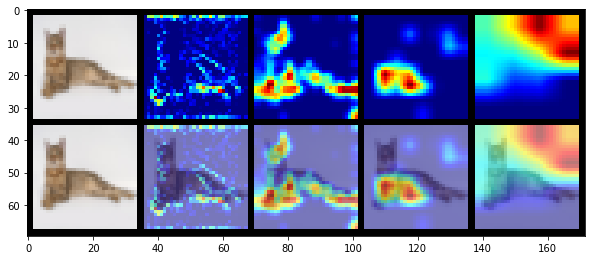

In [77]:
import copy
from torchvision.utils import make_grid, save_image
#import model
for i,k in enumerate(normed_torch_img):
  images1 = [torch_img_list[i].cpu()]
  images2 =  [torch_img_list[i].cpu()]
  b = copy.deepcopy(resnet.to(device))
  layers =  [b.layer1,b.layer2,b.layer3,b.layer4]
  for j in layers:
    g = GradCAM(b,j)
    mask, _= g(normed_torch_img[i])
    heatmap, result = visualize_cam(mask,torch_img_list[i] )
    images1.extend([heatmap])
    images2.extend([result])
  grid_image = make_grid(images1+images2, nrow=5)
  imshow(grid_image)